## reference: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

# Classification on imbalanced data

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use [Keras](https://www.tensorflow.org/guide/keras/overview) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data. .

This tutorial contains complete code to:

* Load a CSV file using Pandazs.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Try common techniques for dealing with imbalanced data like:
    * Class weighting


## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import random
import tempfile
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [3]:
np.random.seed(699)

os.environ['PYTHONHASHSEED'] = '0'
random.seed(699)

# Also set the tf randomness to some fixed values like this if you need:
tf.random.set_seed(699)

In [4]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

### Download the Kaggle Credit Card Fraud data set

Pandas is a Python library with many helpful utilities for loading and working with structured data. It can be used to download CSVs into a Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame).

Note: This dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available [here](https://www.researchgate.net/project/Fraud-detection-5) and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project

In [5]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
path='drive/MyDrive/Capstone(Team10)/code'


file = tf.keras.utils
raw_df = pd.read_csv(path+'/data/rawdata_USA.csv', index_col=0, parse_dates=True)
raw_df.index.name='date'
metadata=pd.read_csv(path+'/data/metadata_final.csv')

raw_df.tail(5)

Mounted at /content/drive


,BNBUCT02,BNEMTE02,BNODTE02,BNRMTE02,BSCICP02,BSCURT02,BSEMFT02,BSOBLV02,BSOITE02,BSPRTE02,...,BBBOASPREAD,SP500,WTI,W875RX1,VIXCLS,RECPROUSM156N,DXY,y_nber,y_oecd,y_agg
date,,,,,,,,,,,,,,,,,,,,,
2023-02-01,NaN,NaN,NaN,NaN,-2.6,78.4,-1.488108,-10.0,-9.904271,-6.838155,...,1.55,3970.153442,76.83,14622.7,20.12,0.36,104.870003,0,0.0,0.0
2023-03-01,NaN,NaN,NaN,NaN,-3.7,77.8,-4.394159,-10.0,-11.664475,-4.339667,...,1.77,4109.312445,73.28,14664.3,21.64,0.32,102.510002,0,0.0,0.0
2023-04-01,NaN,NaN,NaN,NaN,-2.9,78.4,-0.707885,-11.0,-10.242475,-4.047127,...,1.73,4169.481401,79.45,14659.0,17.82,0.22,101.669998,0,0.0,0.0
2023-05-01,NaN,NaN,NaN,NaN,-3.1,78.4,2.680256,-13.0,-17.834084,1.060291,...,1.80,4179.825462,71.58,14702.7,17.64,0.62,104.320000,0,0.0,0.0
2023-06-01,NaN,NaN,NaN,NaN,-4.0,NaN,-5.300056,-9.0,-6.879287,-6.892674,...,1.69,4450.381312,68.11,NaN,14.00,NaN,102.910004,0,0.0,0.0


In [6]:
len(raw_df.columns)

73

### Examine the class label imbalance

Let's look at the dataset imbalance:

In [7]:
neg, pos = np.bincount(raw_df['y_nber'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1074
    Positive: 145 (13.50% of total)



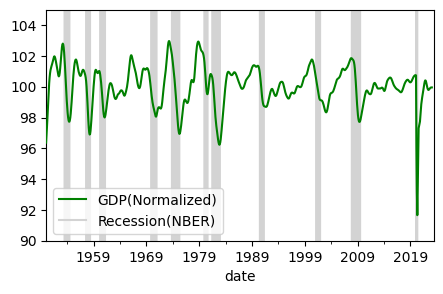

In [8]:
data=raw_df.loc[raw_df.index.year>=1950]

fig, ax=plt.subplots(figsize=(5,3))

lines=data['LORSGPNO'].plot(ax=ax, color=['green'], zorder=200)
area=(data['y_nber']*1000).plot.area(ax=ax, color='#d3d3d3')
ax.set_ylim([90,105])
ax.legend(['GDP(Normalized)','Recession(NBER)'])

In [9]:

neg, pos = np.bincount(raw_df['y_oecd'].dropna())
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 885
    Positive: 382 (43.16% of total)



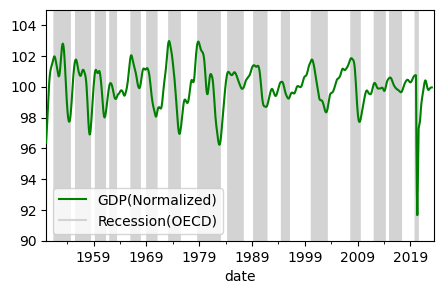

In [10]:
data=raw_df.loc[raw_df.index.year>=1950]

fig, ax=plt.subplots(figsize=(5,3))

lines=data['LORSGPNO'].plot(ax=ax, color=['green'], zorder=200)
area=(data['y_oecd']*1000).plot.area(ax=ax, color='#d3d3d3')
ax.set_ylim([90,105])
ax.legend(['GDP(Normalized)','Recession(OECD)'])

In [11]:
neg, pos1, pos2 = np.bincount(raw_df['y_agg'].dropna())
total = neg + pos1 + pos2
print('Examples:\n    Total: {}\n\
    Positive1: {} ({:.2f}% of total)\n\
    Positive2: {} ({:.2f}% of total)\n'.format(
    total, pos1, 100 * pos1 / total, pos2, 100 * pos2 / total))

Examples:
    Total: 885
    Positive1: 270 (30.51% of total)
    Positive2: 113 (12.77% of total)



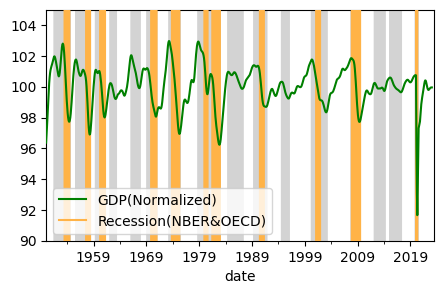

In [12]:
data=raw_df.loc[raw_df.index.year>=1950]

fig, ax=plt.subplots(figsize=(5,3))

lines=data['LORSGPNO'].plot(ax=ax, color=['green'], zorder=200)
area1=(data['y_nber']*1000).plot.area(ax=ax, color='#ffb347', zorder=3)
area2=(data['y_oecd']*1000).plot.area(ax=ax, color='#d3d3d3')

ax.set_ylim([90,105])
ax.legend(['GDP(Normalized)','Recession(NBER&OECD)'])

This shows the small fraction of positive samples.

### Split Dataset into Train, Validation, Test data

We will use last 5 years for final test set. And for cross validation, we will use 5 blocked time-series split.

In [13]:
## specifying variable names for X and y
y_list=list(metadata[metadata.Level=='Recession']['SUBJECT'])
x_list=[x for x in raw_df.columns if x not in y_list]
len(y_list), len(x_list)

## split raw_df into X and y
X=raw_df[x_list]

In [14]:
#metadata.SUBJECT[-20:]  ##BBBYIELD, BBBOASPREAD
(len(X)-X[['BBBYIELD', 'BBBOASPREAD']].isna().sum())/12

BBBYIELD       26.5
BBBOASPREAD    26.5
dtype: float64

In [15]:
## function data transformation
def transform(data, metadata, tcode):

    var_list=list(metadata[metadata.Tcode==tcode]['SUBJECT'])

    sel_list=[x for x in var_list if x in data.columns]

    df=data[sel_list]

#    print(df.head())

    if tcode=='diff':
        df_transform=df.diff()
    elif tcode=='log_diff':
        df_transform=np.log(df/df.shift(1))
    else:
        df_transform=df

    return df_transform


for idx, tcode in enumerate(set(metadata.Tcode.unique())):

    if idx==0:
        X_tr=transform(X, metadata, tcode)
    else:
        df_temp=transform(X, metadata, tcode)
        X_tr=X_tr.merge(df_temp, how='left', left_index=True, right_index=True)

print(X_tr.shape==X.shape)
print(set(X_tr.columns)==set(X.columns))
X_tr.head()


True
True


,VIXCLS,103SPREAD,BBBOASPREAD,LCEAPR01,XTIMVA01,PRMNTO01,MABMM301,PRCNTO01,STMNIS01,SLWHTO02,...,BSXRLV02,BSCURT02,CSESFT02,BNBUCT02,BNEMTE02,BNODTE02,BNRMTE02,3MTBILL,10YT,BBBYIELD
date,,,,,,,,,,,,,,,,,,,,,
1934-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-02-01,NaN,NaN,NaN,NaN,NaN,0.055428,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.10,NaN,NaN
1934-03-01,NaN,NaN,NaN,NaN,NaN,0.038467,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.38,NaN,NaN
1934-04-01,NaN,NaN,NaN,NaN,NaN,0.018683,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.09,NaN,NaN
1934-05-01,NaN,NaN,NaN,NaN,NaN,0.013791,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN,NaN


In [16]:
## extract features with more than 50 years and store the features in selected features
#threshold=55

year_dict=dict(round((len(X_tr)-X_tr.isna().sum())/12,2))

# selected_features=[metadata[metadata.SUBJECT==x]['SUBJECT'].values[0] for x in year_dict.keys() if year_dict[x]>=threshold]
# [metadata[metadata.SUBJECT==x]['Name'].values[0] for x in year_dict.keys() if year_dict[x]>=threshold]

feature_dict={}
thresholds=[30,35,40,45,50,55]

for threshold in thresholds:
  selected_features=[metadata[metadata.SUBJECT==x]['SUBJECT'].values[0] for x in year_dict.keys() if year_dict[x]>=threshold]
  feature_dict[threshold]=selected_features
  print (threshold, 'narrow down to', len(selected_features), 'features.')

30 narrow down to 54 features.
35 narrow down to 51 features.
40 narrow down to 50 features.
45 narrow down to 49 features.
50 narrow down to 46 features.
55 narrow down to 45 features.


In [17]:
for threshold in [30,35,40,45,50]:
  drop_features=[metadata[metadata.SUBJECT==x]['Name'].values[0] for x in feature_dict[threshold] if x not in feature_dict[threshold+5]]
  print('threshold {} to {}: dropped features are '.format(threshold, threshold+5), drop_features)

threshold 30 to 35: dropped features are  ['CBOE Volatility Index: VIX', 'Business tendency surveys (manufacturing) Order books Level National indicator', 'Business tendency surveys (manufacturing) Export order books or demand Level National indicator']
threshold 35 to 40: dropped features are  ['Dollar Index, Monthly end']
threshold 40 to 45: dropped features are  ['Consumer Price Index OECD Groups Housing Total']
threshold 45 to 50: dropped features are  ['Labour Force Survey - quarterly levels Inactive population Aged 15 and over All persons', 'Consumer opinion surveys Consumer prices (inflation) Future tendency National indicator', 'Consumer opinion surveys Economic Situation Future tendency National indicator']
threshold 50 to 55: dropped features are  ['Currency Conversions Real effective exchange rates Overall Economy CPI']


In [18]:
## let's try threshold of 50
threshold=50
selected_features=feature_dict[threshold]
missing_dict=dict(X_tr[selected_features][-(threshold*12+6):].isna().sum())
imputing_varlist=[x for x in missing_dict if (missing_dict[x]>0)]  ##&(missing_dict[x]<10)
print(len(selected_features), len(imputing_varlist))


## reduce the X data for periods 1973.1~2022.12
## variables having only 1~2 missing values --> missing recent values --> cut to available periods(~22.12)
## 'PIEAEN01','PIEAMP01': 6 missing values --> missing recent values --> cut to available periods(~22.12)
## other variables: missing values in the midst of the series --> using linear interpolation
## it turns out that two data series have same values --> so only use 'IR3TCD01'(&drop 'IR3TIB01')
# metadata[metadata.SUBJECT.isin(['IR3TCD01','IR3TIB01'])]['Name'].values
# (X_data['IR3TCD01']==X_data['IR3TIB01']).value_counts()

selected_features=[x for x in selected_features if x!='IR3TIB01']
imputing_varlist=[x for x in imputing_varlist if x in selected_features]

print(len(selected_features), len(imputing_varlist))

for var in imputing_varlist:
  X_tr[var]=X_tr[var].interpolate(method='linear')

46 33
45 32


In [19]:
X_data=X_tr[selected_features][-(threshold*12+6):-6]

print(len(X_data.columns))
print(len(selected_features))

X_data.isna().sum()

with open(path+'/data/X_data_full.pkl','wb') as f:
  pickle.dump(X_data, f)

45
45


In [20]:
## reference : https://gmnam.tistory.com/230#:~:text=class%20BlockingTimeSeriesSplit%28%29%3A%20def%20__init__%28self%2C%20n_splits%29%3A%20self.n_splits%20%3D%20n_splits,indices%20%5Bstart%3A%20mid%5D%2C%20indices%20%5Bmid%20%2B%20margin%3A%20stop%5D


from sklearn.model_selection import TimeSeriesSplit
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

def plot_cv_indices(cv, X, n_splits, lw=10):

    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

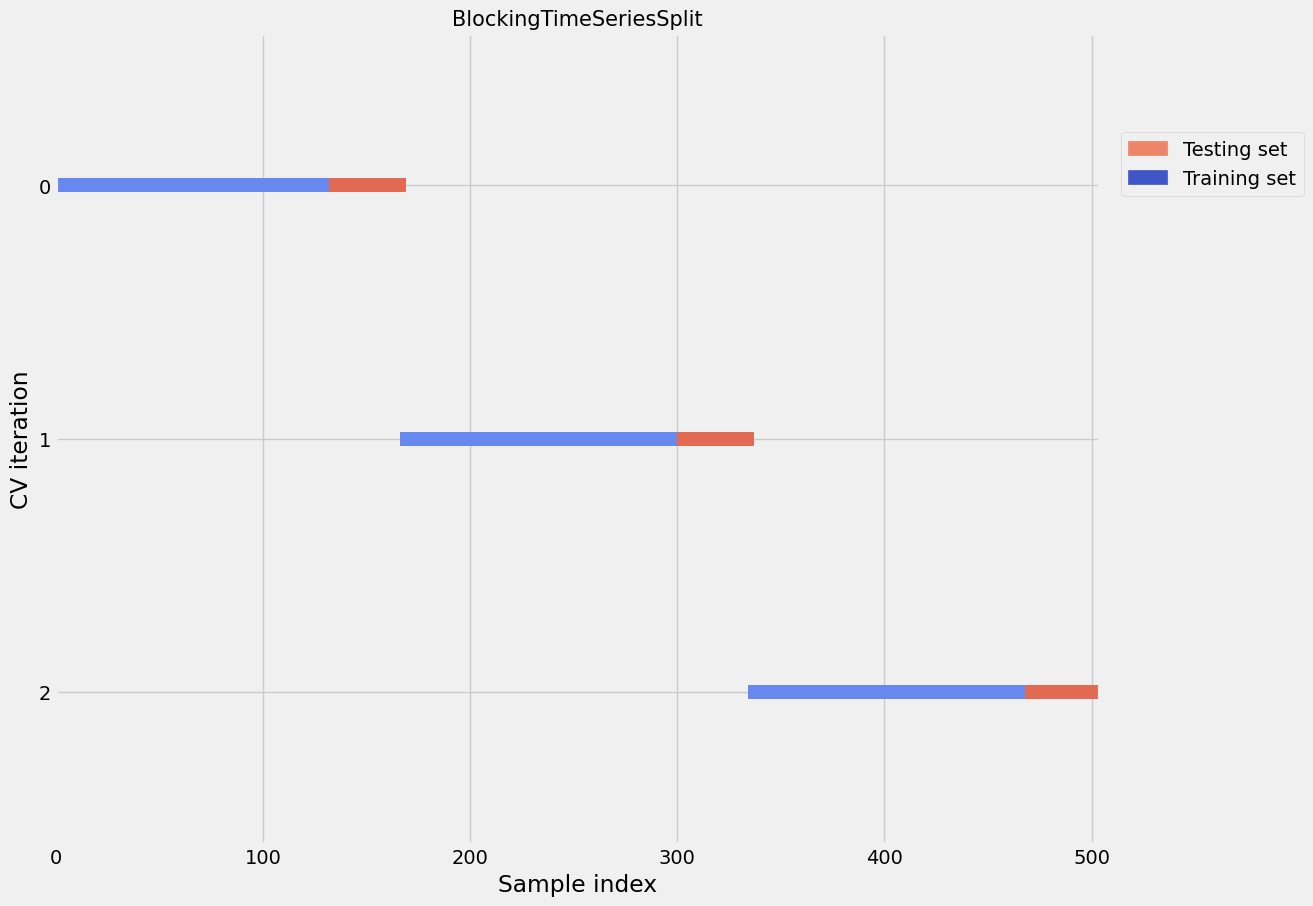

In [21]:
test_year=8
n_splits=3

tss=BlockingTimeSeriesSplit(n_splits=n_splits)
plot_cv_indices(tss, X_data[:-(test_year*12)], n_splits=n_splits)

In [22]:
## make index for train, validation dataset
train_idxs=[]
val_idxs=[]

for train_idx, val_idx in tss.split(X_data[:-(test_year*12)]):
  train_idxs.append(train_idx)
  val_idxs.append(val_idx)

# train_idxs[2], val_idxs[2]  ## train and test dataset in 5th block

In [23]:
## checking if validation dataset in each block contains at least one recession period.

for ytype in ['y_oecd','y_nber','y_agg']:
  y=raw_df[ytype]
  y_data=y[-(threshold*12+6):-6]

  print(ytype)

  for i, idx in enumerate(train_idxs):
    n_pos=y_data[idx].value_counts()[1]
    print('positive class in {} training:'.format(i), n_pos)

  for i, idx in enumerate(val_idxs):
    if y_data[idx].value_counts()[0]==len(val_idxs[i]):
      n_pos=0
    else:
      n_pos=y_data[idx].value_counts()[1]
    print('positive class in {} validation:'.format(i), n_pos)

y_oecd
positive class in 0 training: 71
positive class in 1 training: 45
positive class in 2 training: 44
positive class in 0 validation: 29
positive class in 1 validation: 7
positive class in 2 validation: 22
y_nber
positive class in 0 training: 38
positive class in 1 training: 8
positive class in 2 training: 26
positive class in 0 validation: 0
positive class in 1 validation: 0
positive class in 2 validation: 0
y_agg
positive class in 0 training: 33
positive class in 1 training: 37
positive class in 2 training: 20
positive class in 0 validation: 29
positive class in 1 validation: 7
positive class in 2 validation: 22


Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets.

### Stationarity test for transformed data

In [44]:
from statsmodels.tsa.stattools import adfuller

selected_features=list(X_data.columns)
var_list=[]
pvalue=[]

for idx, var in enumerate(selected_features):
    X=X_data[var].values
    result = adfuller(X)
    var_list.append(var)
    pvalue.append(result[1])

adf_df=pd.DataFrame({'var':var_list,'pvalue':pvalue})
adf_df['stationary']=adf_df['pvalue'].apply(lambda x:1 if x<0.05 else 0)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#  print('\t%s: %.3f' % (key, value))

nonst_varlist=adf_df.loc[adf_df.stationary==0]

## see non-stationary series
print(len(nonst_varlist))
print([metadata[metadata.SUBJECT==x]['Name'].values[0] for x in nonst_varlist['var'].values])
print([metadata[metadata.SUBJECT==x]['Tcode'].values[0] for x in nonst_varlist['var'].values])

3
['Labour Compensation Earnings Private sector Hourly', 'Labour Compensation Earnings Manufacturing Hourly', 'Consumer Price Index OECD Groups All items non-food non-energy Total']
['log_diff', 'log_diff', 'log_diff']


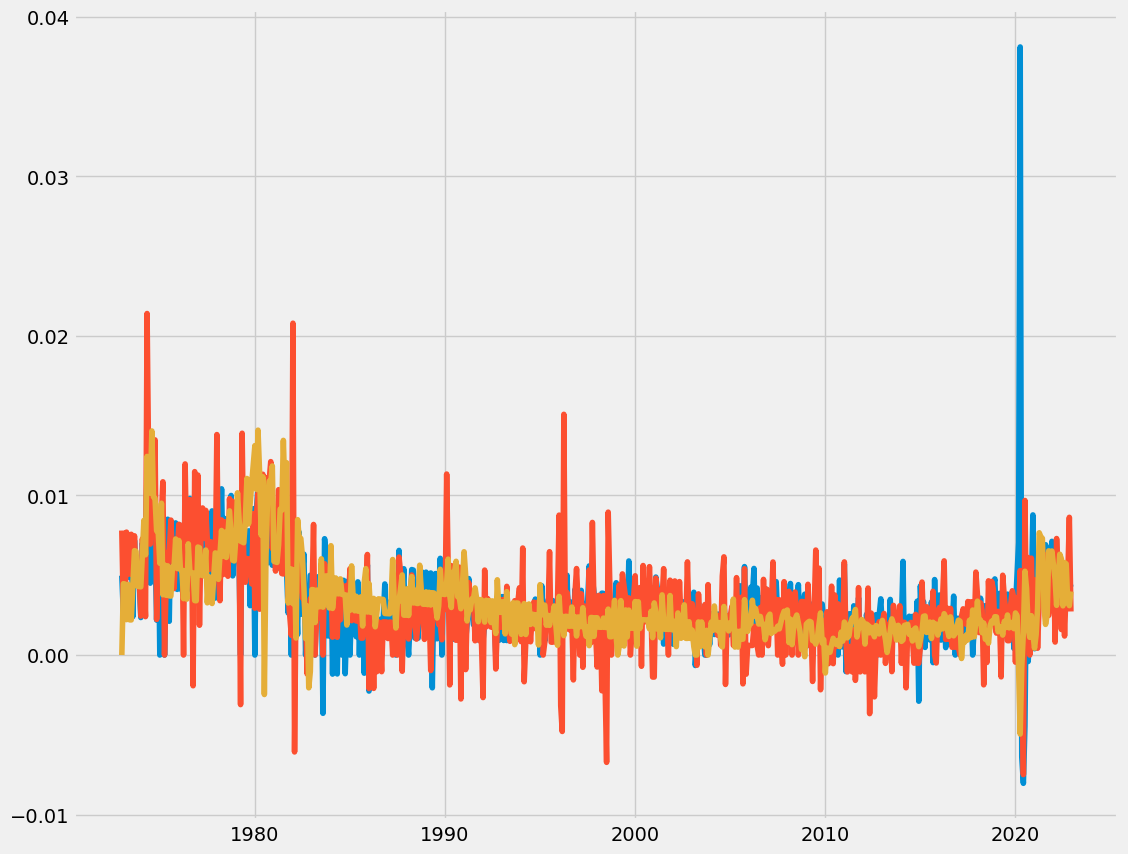

In [39]:
plt.plot(X_data[nonst_varlist['var'].values])